In [25]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [26]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y

In [27]:
path = path = r"G:\AI学习资料\machine-learning-2014\机器学习课程2014源代码\python代码\ex4-NN back propagation\ex4data1.mat"
X, _ = load_data(path)

In [28]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

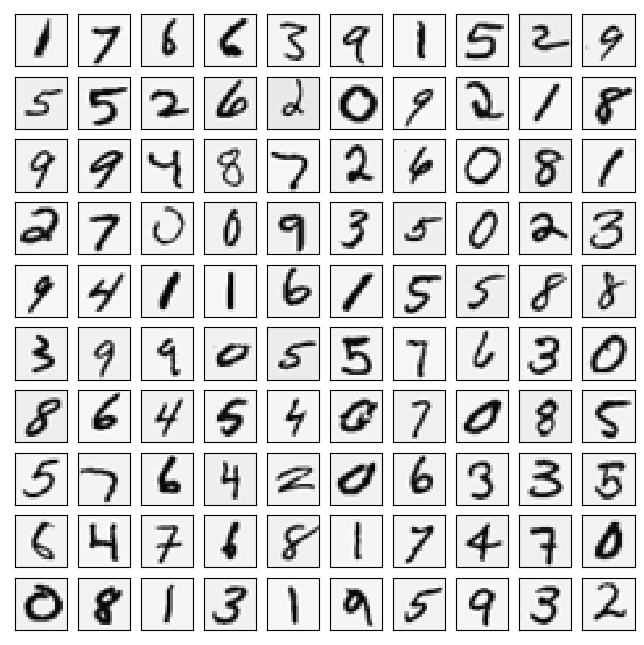

In [29]:
plot_100_image(X)
plt.show()

In [31]:
X_raw, y_raw = load_data(path, transpose=False)
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1)#增加全部为1的一列
X.shape

(5000, 401)

In [32]:
y_raw

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

In [33]:
def expand_y(y):
#     """expand 5000*1 into 5000*10
#     where y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i - 1] = 1

        res.append(y_array)

    return np.array(res)

In [34]:
y = expand_y(y_raw)
y #5000,10

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [44]:
path_w = path = r"G:\AI学习资料\machine-learning-2014\机器学习课程2014源代码\python代码\ex4-NN back propagation\ex4weights.mat"

In [45]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [46]:
t1, t2 = load_weight(path)
t1.shape, t2.shape

((25, 401), (10, 26))

In [47]:
# Define a function 'serialize' to flatten and concatenate two matrices 'a' and 'b'.
# 'a' and 'b' are the input matrices.
def serialize(a, b):
    # Use 'np.ravel' to flatten 'a' and 'b', and then concatenate them.
    return np.concatenate((np.ravel(a), np.ravel(b)))
# Serialize two matrices.
# In this neural network architecture, we have 'theta1' with shape (25, 401) and 'theta2' with shape (10, 26), their gradients are 'delta1' and 'delta2'.

In [48]:
# 't1' and 't2' are the parameter matrices for the first and second layer of the neural network, respectively.
# The 'serialize' function is used to flatten and concatenate 't1' and 't2' into a one-dimensional array 'theta'.
theta = serialize(t1, t2)  # Flatten the parameters, 25*401+10*26=10285
# Print the shape of 'theta' to verify that it has the correct length.
theta.shape

(10285,)

In [49]:
def feed_forward(theta, X):
    """apply to architecture 400+1 * 25+1 *10
    X: 5000 * 401
    """

    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]
    a1 = X  # 5000 * 401

    z2 = a1 @ t1.T  # 5000 * 25
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1)  # 5000*26

    z3 = a2 @ t2.T  # 5000 * 10
    h = sigmoid(z3)  # 5000*10, this is h_theta(X)

    return a1, z2, a2, z3, h  # you need all those for backprop


In [50]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [51]:
def deserialize(seq):
#     """into ndarray of (25, 401), (10, 26)"""
    return seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)

In [52]:
_, _, _, _, h = feed_forward(theta, X)
h # 5000*10

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ..., 4.01468105e-04, 6.48072305e-03,
        9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ..., 2.39107046e-03, 1.97025086e-03,
        9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ..., 6.22892325e-02, 5.49803551e-03,
        9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ..., 2.15667361e-03, 6.49826950e-01,
        2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ..., 1.19366192e-02, 9.71410499e-01,
        2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ..., 5.73434571e-03, 6.96288990e-01,
        8.18576980e-02]])

In [113]:
def cost(theta, X, y):
#     """calculate cost
#     y: (m, k) ndarray
#     """
    m = X.shape[0]  # get the data size m

    _, _, _, _, h = feed_forward(theta, X)

    # np.multiply is pairwise operation
    pair_computation = -np.multiply(y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))

    return pair_computation.sum() / m

In [114]:
def regularized_cost(theta, X, y, l=1):
    """the first column of t1 and t2 is intercept theta, ignore them when you do regularization"""
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    reg_t1 = (l / (2 * m)) * np.power(t1[:, 1:], 2).sum()  # this is how you ignore first col
    reg_t2 = (l / (2 * m)) * np.power(t2[:, 1:], 2).sum()

    return cost(theta, X, y) + reg_t1 + reg_t2

In [115]:
regularized_cost(theta, X, y)

0.38376985909092365

In [116]:
def mycost(theta,X,Y,lamda=1):
    m = X.shape[0]
    Y = Y.T # 10,5000
    theta1, theta2 = deserialize(theta)
    part_one = -((Y * np.log(sigmoid(theta2@np.insert(sigmoid(theta1@X.T),obj=0,values=1,axis=0)))).sum(axis=0)).mean()
    part_two = -(((1-Y) * np.log(1 - sigmoid(theta2@np.insert(sigmoid(theta1@X.T),obj=0,values=1,axis=0)))).sum(axis=0)).mean()
    part_regular = (lamda/(2*m))*((np.power(theta1[:,1:],2)).sum() + (np.power(theta2[:,1:],2)).sum())
    return part_one + part_two + part_regular

In [117]:
mycost(theta, X, y)

0.3837698590909236

In [118]:
def sigmoid_gradient(z):
    """
    pairwise op is key for this to work on both vector and matrix
    """
    return np.multiply(sigmoid(z), 1 - sigmoid(z))
sigmoid_gradient(0)

0.25

In [119]:
def gradient(theta, X, y):
    # initialize
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    delta1 = np.zeros(t1.shape)  # (25, 401)
    delta2 = np.zeros(t2.shape)  # (10, 26)

    a1, z2, a2, z3, h = feed_forward(theta, X)

    for i in range(m):
        a1i = a1[i, :]  # (1, 401)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)

        hi = h[i, :]    # (1, 10)
        yi = y[i, :]    # (1, 10)

        d3i = hi - yi  # (1, 10)

        z2i = np.insert(z2i, 0, np.ones(1))  # make it (1, 26) to compute d2i
        d2i = np.multiply(t2.T @ d3i, sigmoid_gradient(z2i))  # (1, 26)

        # careful with np vector transpose
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  # (1, 25).T @ (1, 401) -> (25, 401)

    delta1 = delta1 / m
    delta2 = delta2 / m

    return serialize(delta1, delta2)

In [120]:
def regularized_gradient(theta, X, y, l=1):
    """don't regularize theta of bias terms"""
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta, X, y))
    t1, t2 = deserialize(theta)

    t1[:, 0] = 0
    reg_term_d1 = (l / m) * t1
    delta1 = delta1 + reg_term_d1

    t2[:, 0] = 0
    reg_term_d2 = (l / m) * t2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)

In [121]:
d1, d2 = deserialize(gradient(theta, X, y))
d1.shape, d2.shape

((25, 401), (10, 26))

In [122]:
# Define a function 'mygradient' to compute the gradient of the regularized cost function for a neural network.
# 'theta' is the parameter vector.
# 'X' is the feature matrix (m x n).
# 'Y' is the target variable (m x k).
# 'lamda' is the regularization parameter.
def mygradient(theta,X,Y,lamda=1):
    # Transpose 'Y' to match the shape of the activations 'a3'.
    Y = Y.T # shape: (k x m)
    # 'm' is the number of training examples.
    m = X.shape[0] # scalar
    # 'theta1' and 'theta2' are the parameter matrices for the first and second layer of the neural network, respectively.
    theta1, theta2 = deserialize(theta) # shape: (s x (n+1)) and (k x (s+1))
    # Initialize the gradient matrices 'Theta1' and 'Theta2'.
    Theta1 = np.zeros_like(theta1) # shape: (s x (n+1))
    Theta2 = np.zeros_like(theta2) # shape: (k x (s+1))
    # Compute the activations 'a1', 'a2', and 'a3' for the three layers.
    a1 = np.delete(X.T,obj=0,axis=0) # shape: (n x m)
    a2 = sigmoid(theta1@np.insert(a1,obj=0,values=1,axis=0)) # shape: (s x m)
    a3 = sigmoid(theta2@np.insert(a2,obj=0,values=1,axis=0)) # shape: (k x m)
    # Compute the error terms 'deta3' and 'deta2' for the output layer and the hidden layer, respectively.
    deta3 = a3 - Y # shape: (k x m)
    deta2 = np.delete(theta2.T@deta3,obj=0,axis=0)*a2*(1-a2) # shape: (s x m)
    # Compute the gradients 'Theta1' and 'Theta2' using backpropagation.
    for i in range(X.shape[0]):
        Theta1+=deta2[:,i][:,np.newaxis]@np.insert(a1[:,i][np.newaxis,:],obj=0,values=1,axis=1) # shape: (s x (n+1))
        Theta2+=deta3[:,i][:,np.newaxis]@np.insert(a2[:,i][np.newaxis,:],obj=0,values=1,axis=1) # shape: (k x (s+1))
    # Average the gradients over the number of training examples.
    Theta1, Theta2 = (1/m)*Theta1, (1/m)*Theta2 # shape: (s x (n+1)) and (k x (s+1))
    # Compute the regularization term for the gradients.
    Theta1_0, Theta2_0 = Theta1[:,[0]], Theta2[:,[0]] # shape: (s x 1) and (k x 1)
    Theta1 += (lamda/m)*theta1 # shape: (s x (n+1))
    Theta2 += (lamda/m)*theta2 # shape: (k x (s+1))
    # Exclude the bias term from the regularization.
    Theta1[:,[0]], Theta2[:,[0]] = Theta1_0, Theta2_0 # shape: (s x (n+1)) and (k x (s+1))
    # Flatten and concatenate 'Theta1' and 'Theta2'.
    return np.concatenate((Theta1, Theta2),axis=None) # shape: ((s*(n+1)) + (k*(s+1)),)

In [123]:
myd1, myd2 = deserialize(mygradient(theta, X, y))
myd1.shape, myd2.shape

((25, 401), (10, 26))

In [133]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

In [134]:
def nn_training(X, y):
    """regularized version
    the architecture is hard coded here... won't generalize
    """
    init_theta = random_init(10285)  # 25*401 + 10*26

    res = opt.minimize(fun=mycost,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=mygradient,
                       options={'maxfun': 400})
    return res

In [135]:
res = nn_training(X, y)# slowly
res

C:\Users\wenming\AppData\Local\Temp\ipykernel_10600\347648022.py:6: RuntimeWarning: divide by zero encountered in log
  part_two = -(((1-Y) * np.log(1 - sigmoid(theta2@np.insert(sigmoid(theta1@X.T),obj=0,values=1,axis=0)))).sum(axis=0)).mean()
C:\Users\wenming\AppData\Local\Temp\ipykernel_10600\347648022.py:6: RuntimeWarning: invalid value encountered in multiply
  part_two = -(((1-Y) * np.log(1 - sigmoid(theta2@np.insert(sigmoid(theta1@X.T),obj=0,values=1,axis=0)))).sum(axis=0)).mean()


     fun: 0.326545872188981
     jac: array([ 1.63513466e-04, -2.03863542e-07, -1.30914813e-06, ..., -2.66007359e-04, -9.13214958e-05,
       -1.18809932e-04])
 message: 'Linear search failed'
    nfev: 321
     nit: 19
  status: 4
 success: False
       x: array([-1.92833095e+00, -1.01931771e-03, -6.54574065e-03, ...,  9.69663412e-01, -7.95615838e-01,
        5.21090536e-01])

In [136]:
y_raw

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

In [137]:
final_theta = res.x
def show_accuracy(theta, X, y):
    _, _, _, _, h = feed_forward(theta, X)

    y_pred = np.argmax(h, axis=1) + 1

    print(classification_report(y, y_pred))


In [138]:
show_accuracy(final_theta,X,y_raw)

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       500
           2       0.99      0.99      0.99       500
           3       1.00      0.99      0.99       500
           4       0.99      0.99      0.99       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      1.00      1.00       500
           8       1.00      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       1.00      1.00      1.00       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

